In [1]:
from related_posts_generator import Post, get_all_posts
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
from pathlib import Path
from tqdm.notebook import trange, tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")
%matplotlib widget

[nltk_data] Downloading package punkt to /home/wint3rmute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:

def get_all_posts_oscean() -> list[Post]:
    all_posts = []
    all_posts_paths = Path.glob(Path("/home/wint3rmute/oscean/site/"), "**/*.html")
    all_posts_paths = [path for path in all_posts_paths]

    for post_path in tqdm(all_posts_paths):
        # print(post_path)
        all_posts.append(Post.from_path(post_path))

    return all_posts

all_posts = get_all_posts() #_oscean()

In [30]:
# all_posts[1]

In [31]:
def custom_tokenizer(text: str) -> list[str]:
    stemmer = SnowballStemmer("english")
    words = word_tokenize(text) 
    
    return [stemmer.stem(word) for word in words]

In [32]:

# Vectorizer to convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

# Learn vocabulary and idf, return term-document matrix.
tfidf = vectorizer.fit_transform([post.content for post in all_posts])

umap_result = umap.UMAP().fit_transform(
    tfidf
)

In [33]:
sorted(list(vectorizer.vocabulary_.keys()))[:30]

['!',
 '#',
 '%',
 '&',
 "''",
 '(',
 ')',
 '+',
 ',',
 '-',
 '--',
 '.',
 '.nix',
 '//ccrma.stanford.edu/~jos/filters/why_learn_about_filters.html',
 '//en.m.wikipedia.org/wiki/musique_concr',
 '//flashcrash.net/',
 '//github.com/adaltas/ece-devops-2020-fal',
 '//justiceharvard.org/justicecourse/',
 '//llllllll.co/t/flash-crash-monthly-livecoding-stream-archive/45273/3',
 '//llllllll.co/t/generative-visuals-video-graphics-art-etc/2658/8',
 '//llllllll.co/t/mangling-manipulating-digital-physical-media-like-analog/54876',
 '//media.libreplanet.org/u/libreplanet/m/software-doldrums/',
 '//naiwarszawa.pl/',
 '//sanjayasubedi.com.np/nlp/nlp-with-python-nearest-neighbor-search/',
 '//satrevolution.com/',
 '/bumblebees/pug.jpg',
 '/bumblebees/rabbit.jpg',
 '/grandma_tape_and_radio_player.jpg',
 '/old_radio_duszniki.jpg',
 '/olsztyn-festival-logo.jpg']

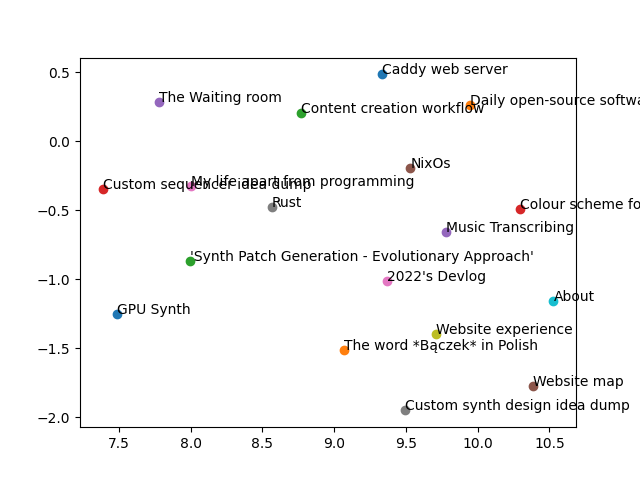

In [34]:
plt.close()

from itertools import count
import random
# index = count()
for post, post_position, post_index in zip(all_posts, umap_result, count()):
    plt.scatter(post_position[0], post_position[1])
    
    # if random.choice([1,2]) == 1:
    plt.annotate(post.title, post_position, post_position)

plt.show()